In [4]:
# google driveのマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# sys.pathの設定
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

deep convolution network

In [10]:
import pickle
import numpy as np
from collections import OrderedDict
from common import layers
from common import optimizer
from data.mnist import load_mnist
import matplotlib.pyplot as plt

class DeepConvNet:
  '''
  conv - relu - conv - relu - pool -
  conv - relu - conv - relu - pool -
  conv - relu - conv - relu - pool -
  affine - relu - dropout - affine - dropout - softmax
  '''
  # conv - relu - pool - conv - relu - pool - affine - relu - affine - softmax で構成
  def __init__(self, input_dim=(1, 28, 28), 
               conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
               conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
               conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
               conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
               conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
               conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
               hidden_size=100, output_size=10):
    
    # 重みの初期化
    # 各層のニューロン一つあたりが、前層のニューロンと幾つの繋がりがあるか
    pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
    weight_init_scales = np.sqrt(2.0 / pre_node_nums)  # Heの初期値
        
    self.params = {}
    pre_channel_num = input_dim[0]
    for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
        self.params['W' + str(idx+1)] = weight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
        self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
        pre_channel_num = conv_param['filter_num']
    self.params['W7'] = weight_init_scales[6] * np.random.randn(pre_node_nums[6], hidden_size)
    print(self.params['W7'].shape)
    self.params['b7'] = np.zeros(hidden_size)
    self.params['W8'] = weight_init_scales[7] * np.random.randn(pre_node_nums[7], output_size)
    self.params['b8'] = np.zeros(output_size)

    # レイヤの生成
    self.layers = []
    self.layers.append(layers.Convolution(self.params['W1'], self.params['b1'], 
                       conv_param_1['stride'], conv_param_1['pad']))
    self.layers.append(layers.Relu())
    self.layers.append(layers.Convolution(self.params['W2'], self.params['b2'], 
                       conv_param_2['stride'], conv_param_2['pad']))
    self.layers.append(layers.Relu())
    self.layers.append(layers.Pooling(pool_h=2, pool_w=2, stride=2))
    self.layers.append(layers.Convolution(self.params['W3'], self.params['b3'], 
                       conv_param_3['stride'], conv_param_3['pad']))
    self.layers.append(layers.Relu())
    self.layers.append(layers.Convolution(self.params['W4'], self.params['b4'],
                       conv_param_4['stride'], conv_param_4['pad']))
    self.layers.append(layers.Relu())
    self.layers.append(layers.Pooling(pool_h=2, pool_w=2, stride=2))
    self.layers.append(layers.Convolution(self.params['W5'], self.params['b5'],
                       conv_param_5['stride'], conv_param_5['pad']))
    self.layers.append(layers.Relu())
    self.layers.append(layers.Convolution(self.params['W6'], self.params['b6'],
                       conv_param_6['stride'], conv_param_6['pad']))
    self.layers.append(layers.Relu())
    self.layers.append(layers.Pooling(pool_h=2, pool_w=2, stride=2))
    self.layers.append(layers.Affine(self.params['W7'], self.params['b7']))
    self.layers.append(layers.Relu())
    self.layers.append(layers.Dropout(0.5))
    self.layers.append(layers.Affine(self.params['W8'], self.params['b8']))
    self.layers.append(layers.Dropout(0.5))
        
    self.last_layer = layers.SoftmaxWithLoss()


  def predict(self, x, train_flg=False):
    for layer in self.layers:
      if isinstance(layer, layers.Dropout):
        x = layer.forward(x, train_flg)
      else:
        x = layer.forward(x)
    return x
        
  def loss(self, x, d):
    y = self.predict(x, train_flg=True)
    return self.last_layer.forward(y, d)

  def accuracy(self, x, d, batch_size=100):
    if d.ndim != 1 : d = np.argmax(d, axis=1)
        
    acc = 0.0
        
    for i in range(int(x.shape[0] / batch_size)):
        tx = x[i*batch_size:(i+1)*batch_size]
        td = d[i*batch_size:(i+1)*batch_size]
        y = self.predict(tx, train_flg=False)
        y = np.argmax(y, axis=1)
        acc += np.sum(y == td) 
        
    return acc / x.shape[0]

  def gradient(self, x, d):
    # forward
    self.loss(x, d)
        
    # backward
    dout = 1
    dout = self.last_layer.backward(dout)

    tmp_layers = self.layers.copy()        
    tmp_layers.reverse()
    for layer in tmp_layers:
        dout = layer.backward(dout)

    # 設定
    grads = {}
    for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
        grads['W' + str(i+1)] = self.layers[layer_idx].dW
        grads['b' + str(i+1)] = self.layers[layer_idx].db

    return grads


(1024, 100)
Generation: 10.正答率（train) = 0.33
             :10.正答率(test) =0.233
Generation: 20.正答率（train) = 0.42
             :20.正答率(test) =0.434
Generation: 30.正答率（train) = 0.64
             :30.正答率(test) =0.554
Generation: 40.正答率（train) = 0.79
             :40.正答率(test) =0.744
Generation: 50.正答率（train) = 0.86
             :50.正答率(test) =0.791
Generation: 60.正答率（train) = 0.92
             :60.正答率(test) =0.872
Generation: 70.正答率（train) = 0.87
             :70.正答率(test) =0.866
Generation: 80.正答率（train) = 0.89
             :80.正答率(test) =0.896
Generation: 90.正答率（train) = 0.92
             :90.正答率(test) =0.908
Generation: 100.正答率（train) = 0.95
             :100.正答率(test) =0.912


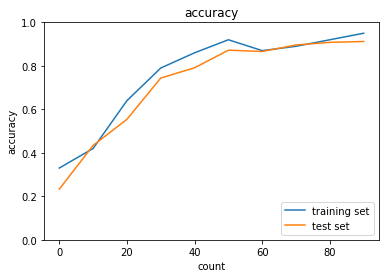

In [11]:

# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]

network = DeepConvNet()
optimizer = optimizer.Adam()

iters_num = 100
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval = 10

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  d_batch = d_train[batch_mask]

  # 勾配
  grad = network.gradient(x_batch, d_batch)
  optimizer.update(network.params, grad)

  loss = network.loss(x_batch, d_batch)
  train_loss_list.append(loss)


  if (i + 1) % plot_interval == 0:
    accr_train = network.accuracy(x_batch, d_batch)
    accuracies_train.append(accr_train)
    accr_test = network.accuracy(x_test, d_test)
    accuracies_test.append(accr_test)

    print('Generation: '+ str(i+1) + '.正答率（train) = ' + str(accr_train))
    print('             :' + str(i+1) + '.正答率(test) =' + str(accr_test))

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label='training set')
plt.plot(lists, accuracies_test, label='test set')
plt.legend(loc='lower right')
plt.title('accuracy')
plt.xlabel('count')
plt.ylabel('accuracy')
plt.ylim(0, 1.0)
# グラフの表示
plt.show()
